In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

In [2]:
current_env = "local"

if current_env == "local":
    data_path = "../ump-dataset"

elif current_env == "kaggle":
    data_path = "../input/ump-dataset"
    
elif current_env == "colab":
    pass

print("data_path:", data_path)

data_path: ../ump-dataset


***
## loading data

In [3]:
features = [f"f_{i}" for i in range(300)]

features = pd.read_parquet(f"{data_path}/train.parquet", columns=features)
display(features)

target = pd.read_parquet(f"{data_path}/train.parquet", columns=["target",])
display(target)

time = pd.read_parquet(f"{data_path}/train.parquet", columns=["time_id",])
display(time)

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0.932573,0.113691,-0.402206,0.378386,-0.203938,-0.413469,0.965623,1.230508,0.114809,-2.012777,...,0.366028,-1.095620,0.200075,0.819155,0.941183,-0.086764,-1.087009,-1.044826,-0.287605,0.321566
1,0.810802,-0.514115,0.742368,-0.616673,-0.194255,1.771210,1.428127,1.134144,0.114809,-0.219201,...,-0.154193,0.912726,-0.734579,0.819155,0.941183,-0.387617,-1.087009,-0.929529,-0.974060,-0.343624
2,0.393974,0.615937,0.567806,-0.607963,0.068883,-1.083155,0.979656,-1.125681,0.114809,-1.035376,...,-0.138020,0.912726,-0.551904,-1.220772,-1.060166,-0.219097,-1.087009,-0.612428,-0.113944,0.243608
3,-2.343535,-0.011870,1.874606,-0.606346,-0.586827,-0.815737,0.778096,0.298990,0.114809,-1.176410,...,0.382201,0.912726,-0.266359,-1.220772,0.941183,-0.609113,0.104928,-0.783423,1.151730,-0.773309
4,0.842057,-0.262993,2.330030,-0.583422,-0.618392,-0.742814,-0.946789,1.230508,0.114809,-0.005858,...,-0.170365,0.912726,-0.741355,-1.220772,0.941183,-0.588445,0.104928,0.753279,1.345611,-0.737624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3141405,0.093530,-0.720275,-0.345497,-0.438781,-0.166972,-0.437182,1.475746,1.284423,0.056425,-1.433681,...,-0.285908,-1.232434,-0.660579,0.875537,0.421628,-0.428097,-0.075548,-0.533092,-0.193732,-0.581394
3141406,-1.344935,-0.199987,-0.107702,-0.454677,-0.221914,-0.141174,-1.498235,1.373834,0.056425,-1.211572,...,0.184517,-1.232434,-0.670493,0.875537,0.421628,-0.729949,-1.514277,0.013145,-0.890270,-0.589705
3141407,0.979489,-1.110491,1.006980,-0.467307,-0.159549,1.355671,0.150812,-0.088923,0.056425,0.996380,...,-0.756332,-1.232434,0.820784,-1.142157,0.421628,-0.363329,1.363181,-0.079106,-1.580124,-0.297625
3141408,-2.565332,0.320301,0.076600,1.380182,-0.155366,-0.689000,0.381069,-1.324759,0.056425,-1.111730,...,-0.756332,-1.232434,0.133074,-1.142157,0.421628,-0.375288,-1.514277,-0.973762,0.608647,-0.372040


,target
0,-0.300875
1,-0.231040
2,0.568807
3,-1.064780
4,-0.531940
...,...
3141405,0.033600
3141406,-0.223264
3141407,-0.559415
3141408,0.009599


,time_id
0,0
1,0
2,0
3,0
4,0
...,...
3141405,1219
3141406,1219
3141407,1219
3141408,1219


In [4]:
time_ids = np.sort(time.time_id.unique())
len(time_ids)

1211

In [5]:
n_time_steps = len(time_ids)
print("time steps:", n_time_steps)

valid_prop = 0.1
valid_size = int(0.1 * n_time_steps)
print("valid size:", valid_size)

time steps: 1211
valid size: 121


In [6]:
# train-valid splits
n_splits = 3
end_idx = n_time_steps 

splits = list()

for start_idx in np.arange(1211, 0, -valid_size)[1:n_splits+1]:
    valid_time_ids = time_ids[start_idx:end_idx]
    train_time_end = time_ids[start_idx]-1
    end_idx = start_idx
    
    train_idx = time.query("time_id <= @train_time_end").index
    valid_idx = time.query("time_id in @valid_time_ids").index
    splits.append((train_idx,valid_idx))

In [7]:
import gc
gc.collect()

231

***
## model training: finding number of iterations

In [8]:
def pearsonr(preds: np.array, dset: lgb.Dataset):
    """
    Helper function to compute Pearson correlation 
    on validation dataset for LightGBM as tracking metric.
    Args:
        preds: 1d-array with the model predictions
        dset: LightGBM dataset with the labels
    Returs:
        Tuple with the corresponding output
    """
    labels = dset.get_label()
    return 'pearsonr', stats.pearsonr(preds, labels)[0], True

In [9]:
model_params = {
    'linear_tree': True,
    'objective': 'mse',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'force_col_wise': True,
    'bagging_freq': 1,
    'seed': 19,
    'first_metric_only': False,
    'bin_construct_sample_cnt': 100000000,
    'feature_pre_filter': False,
    'bagging_fraction': 0.9,
    'feature_fraction': 0.2,
    'lambda_l1': 0.007523622054560796,
    'lambda_l2': 0.0018848586384901094,
    'linear_lambda': 23.556574210240964,
    'min_data_in_leaf': 500,
    'path_smooth': 9.2943778947972,
    'num_leaves': 64,
}

[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 2740634, number of used features: 300
[LightGBM] [Info] Start training from score -0.022338
[20]	valid_0's rmse: 0.898194	valid_0's pearsonr: 0.132817
[40]	valid_0's rmse: 0.896596	valid_0's pearsonr: 0.133981
[60]	valid_0's rmse: 0.895764	valid_0's pearsonr: 0.136552
[80]	valid_0's rmse: 0.895255	valid_0's pearsonr: 0.138158
[100]	valid_0's rmse: 0.894977	valid_0's pearsonr: 0.138705
[120]	valid_0's rmse: 0.894792	valid_0's pearsonr: 0.139127
[140]	valid_0's rmse: 0.894706	valid_0's pearsonr: 0.139148
[160]	valid_0's rmse: 0.894597	valid_0's pearsonr: 0.139387
[180]	valid_0's rmse: 0.894536	valid_0's pearsonr: 0.13944
[200]	valid_0's rmse: 0.894435	valid_0's pearsonr: 0.139946
[220]	valid_0's rmse: 0.894284	valid_0's pearsonr: 0.140956
[240]	valid_0's rmse: 0.894239	valid_0's pearsonr: 0.141158
[260]	valid_0's rmse: 0.894214	valid_0's pearsonr: 0.141248
[280]	valid_0's rmse: 0.894158	valid_0's

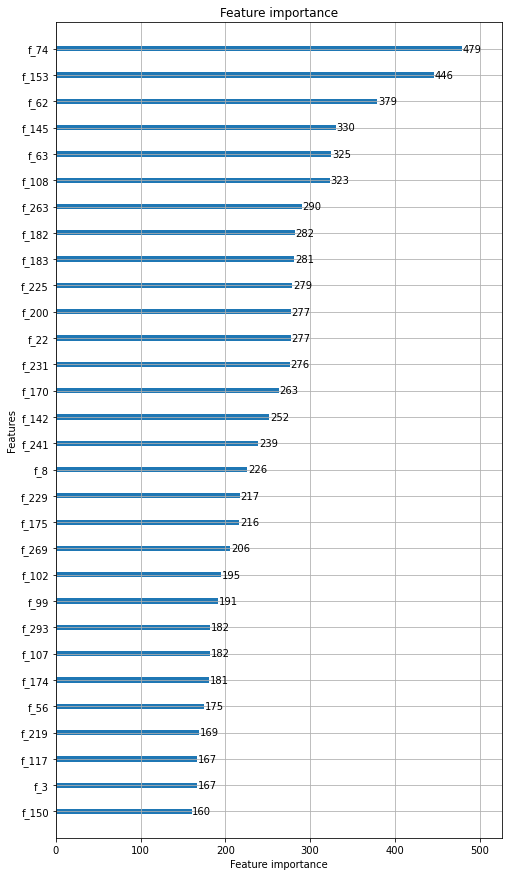

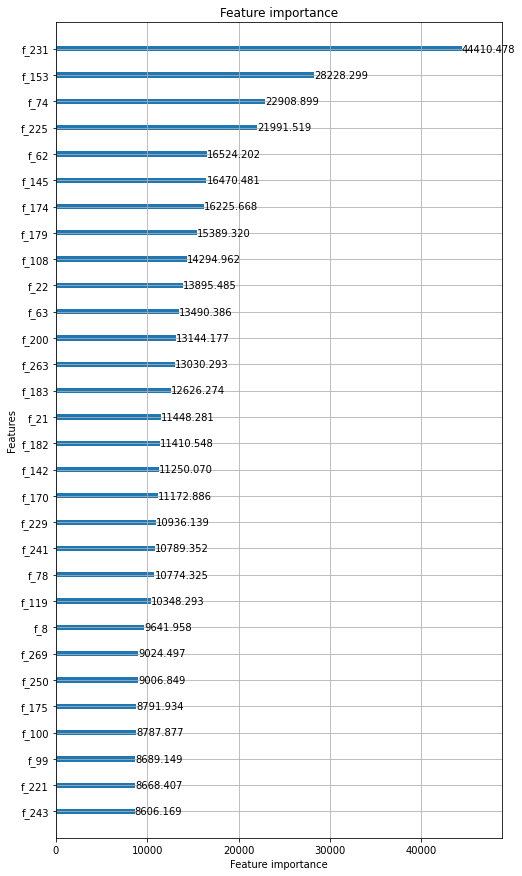

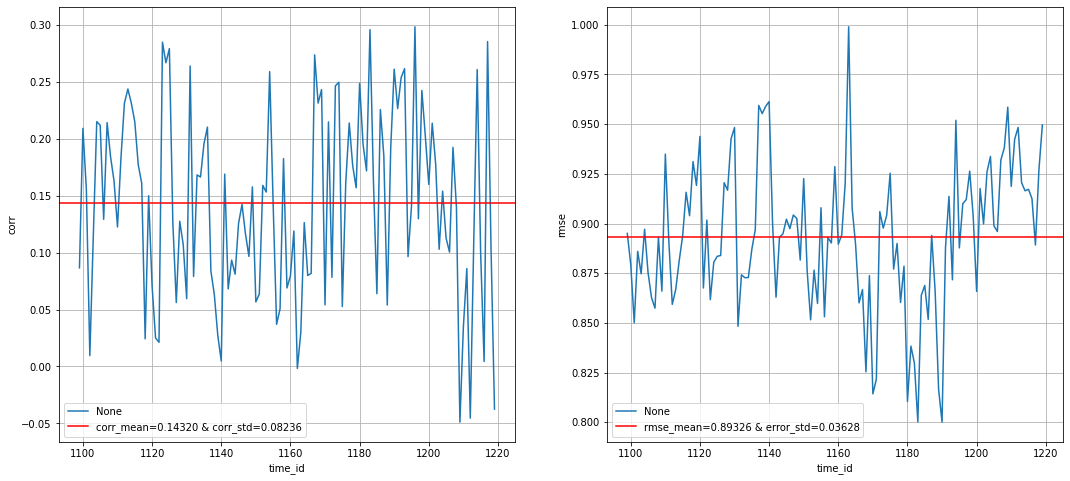

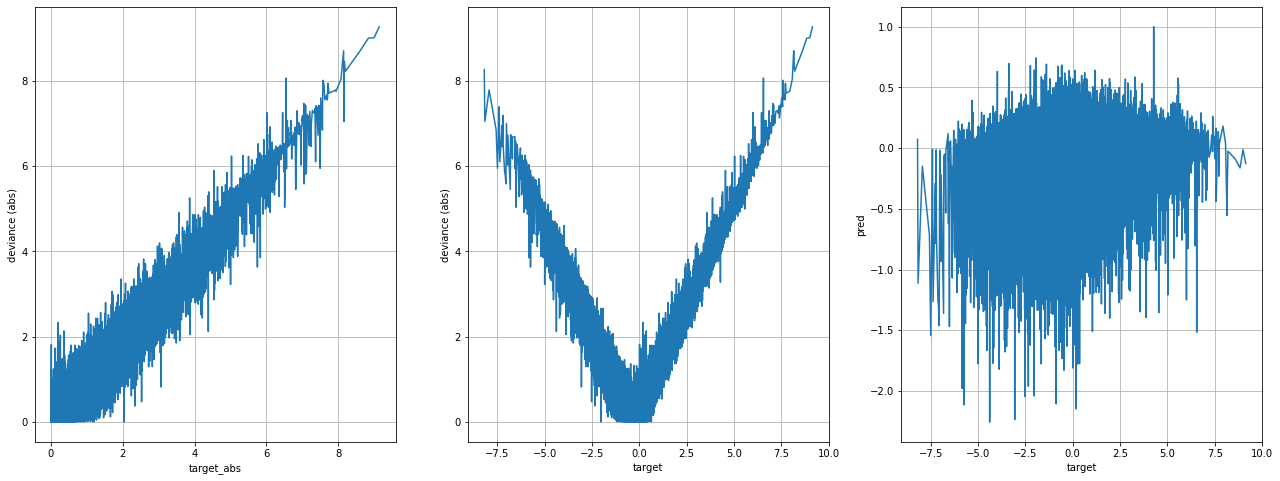

[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 2364296, number of used features: 300
[LightGBM] [Info] Start training from score -0.024609
[20]	valid_0's rmse: 0.905946	valid_0's pearsonr: 0.117592
[40]	valid_0's rmse: 0.904316	valid_0's pearsonr: 0.123928
[60]	valid_0's rmse: 0.903347	valid_0's pearsonr: 0.129608
[80]	valid_0's rmse: 0.902699	valid_0's pearsonr: 0.133355
[100]	valid_0's rmse: 0.902267	valid_0's pearsonr: 0.135547
[120]	valid_0's rmse: 0.901945	valid_0's pearsonr: 0.13719
[140]	valid_0's rmse: 0.901771	valid_0's pearsonr: 0.137891
[160]	valid_0's rmse: 0.901616	valid_0's pearsonr: 0.138491
[180]	valid_0's rmse: 0.901449	valid_0's pearsonr: 0.13942
[200]	valid_0's rmse: 0.901306	valid_0's pearsonr: 0.140191
[220]	valid_0's rmse: 0.901236	valid_0's pearsonr: 0.14045
[240]	valid_0's rmse: 0.901202	valid_0's pearsonr: 0.140492
[260]	valid_0's rmse: 0.901129	valid_0's pearsonr: 0.140892
[280]	valid_0's rmse: 0.901045	valid_0's p

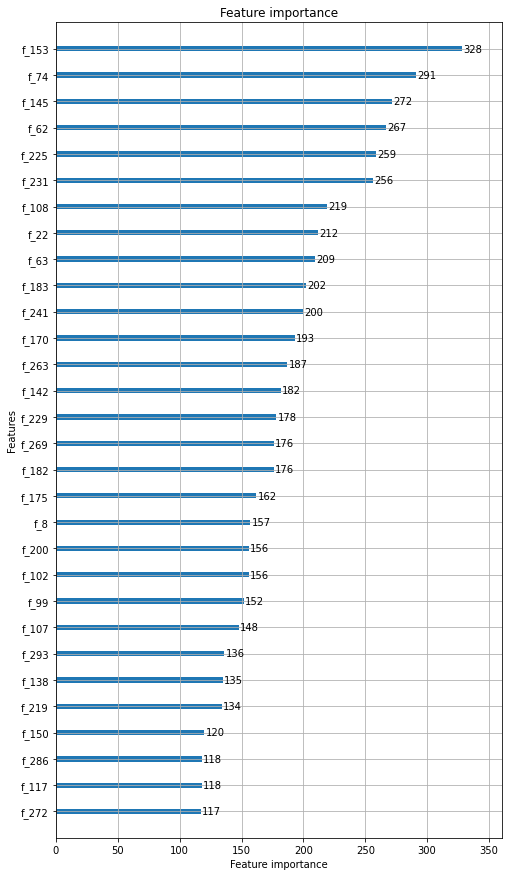

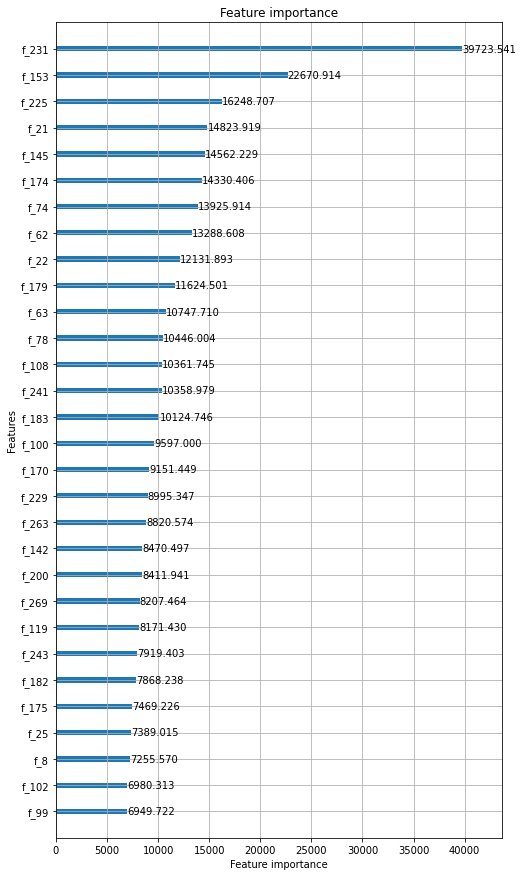

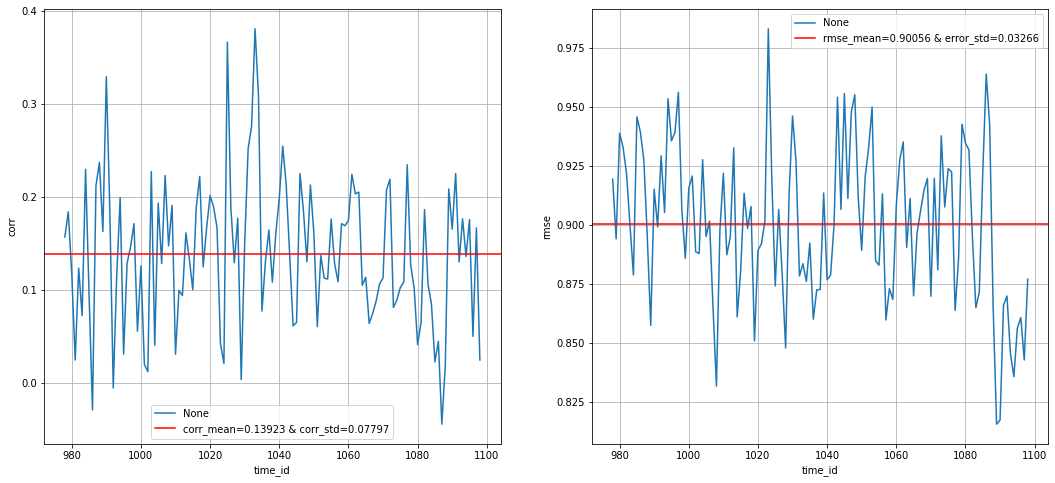

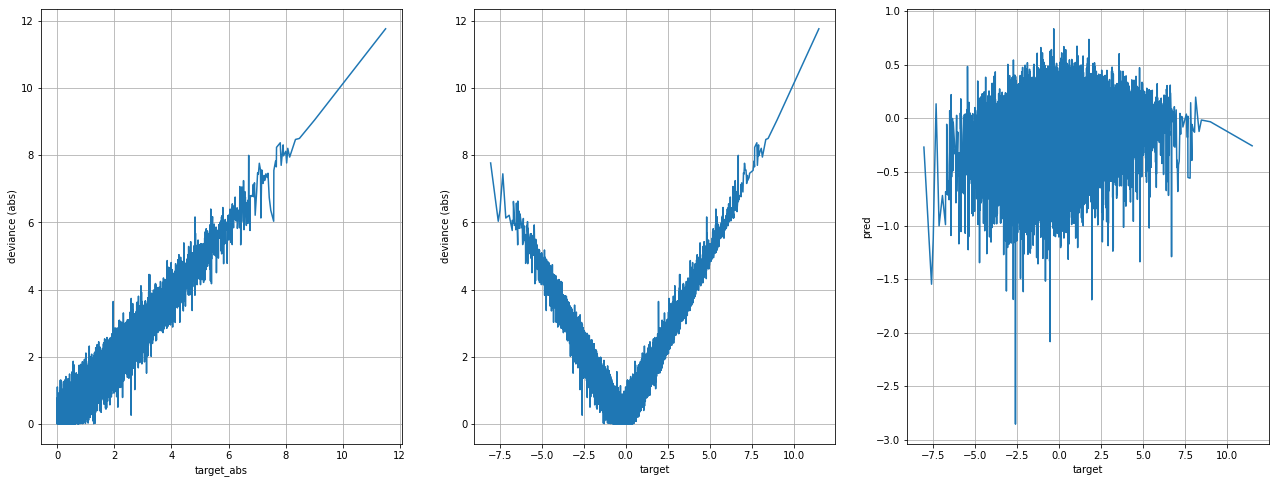

[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 1995404, number of used features: 300
[LightGBM] [Info] Start training from score -0.026871
[20]	valid_0's rmse: 0.940244	valid_0's pearsonr: 0.0996904
[40]	valid_0's rmse: 0.938697	valid_0's pearsonr: 0.110041
[60]	valid_0's rmse: 0.937973	valid_0's pearsonr: 0.114784
[80]	valid_0's rmse: 0.937404	valid_0's pearsonr: 0.11903
[100]	valid_0's rmse: 0.936949	valid_0's pearsonr: 0.122445
[120]	valid_0's rmse: 0.936623	valid_0's pearsonr: 0.124715
[140]	valid_0's rmse: 0.93626	valid_0's pearsonr: 0.127578
[160]	valid_0's rmse: 0.93597	valid_0's pearsonr: 0.129697
[180]	valid_0's rmse: 0.935786	valid_0's pearsonr: 0.130949
[200]	valid_0's rmse: 0.935564	valid_0's pearsonr: 0.132557
[220]	valid_0's rmse: 0.935432	valid_0's pearsonr: 0.133451
[240]	valid_0's rmse: 0.935251	valid_0's pearsonr: 0.134793
[260]	valid_0's rmse: 0.935069	valid_0's pearsonr: 0.136135
[280]	valid_0's rmse: 0.934901	valid_0's 

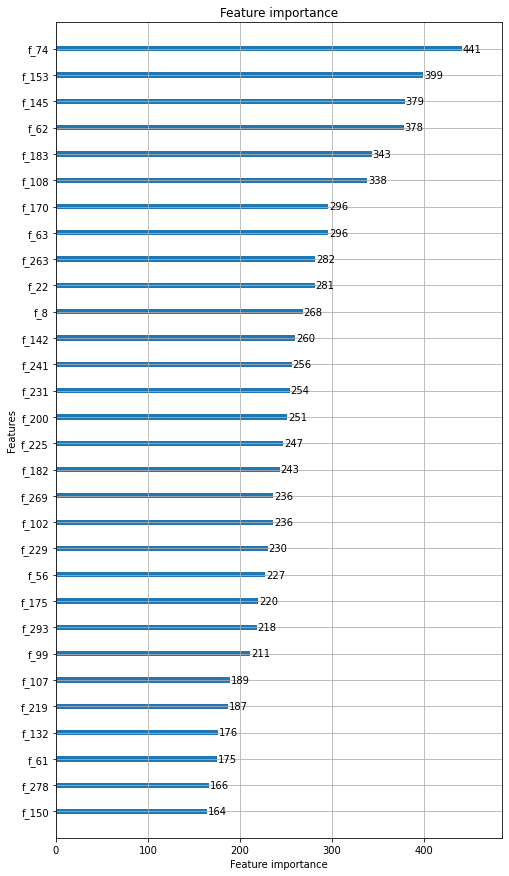

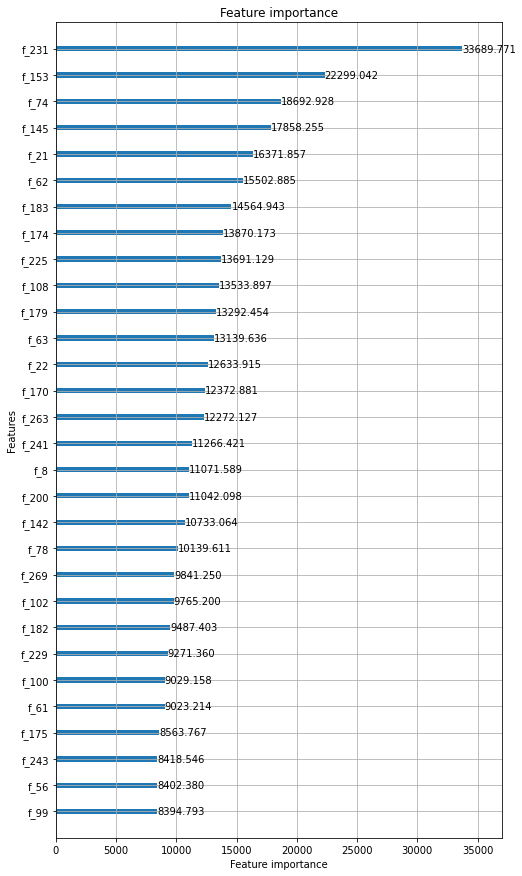

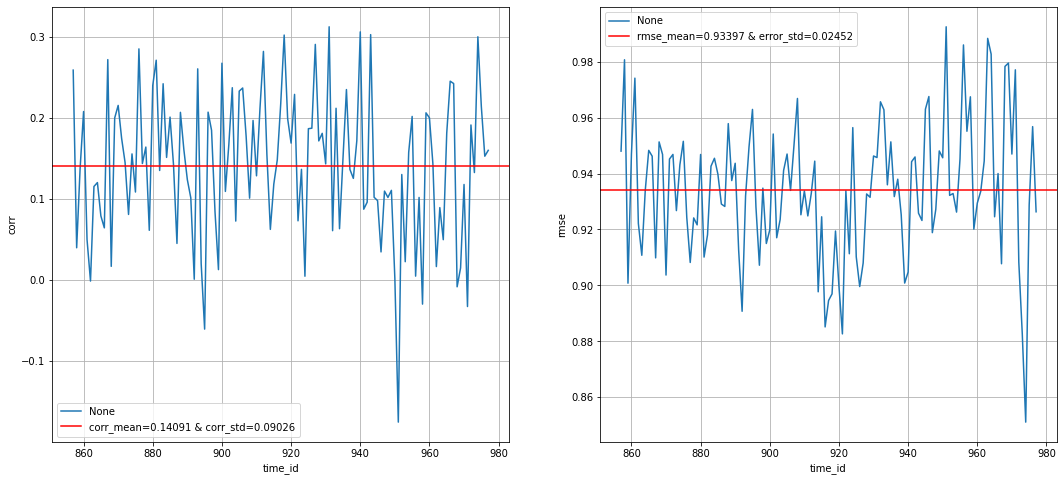

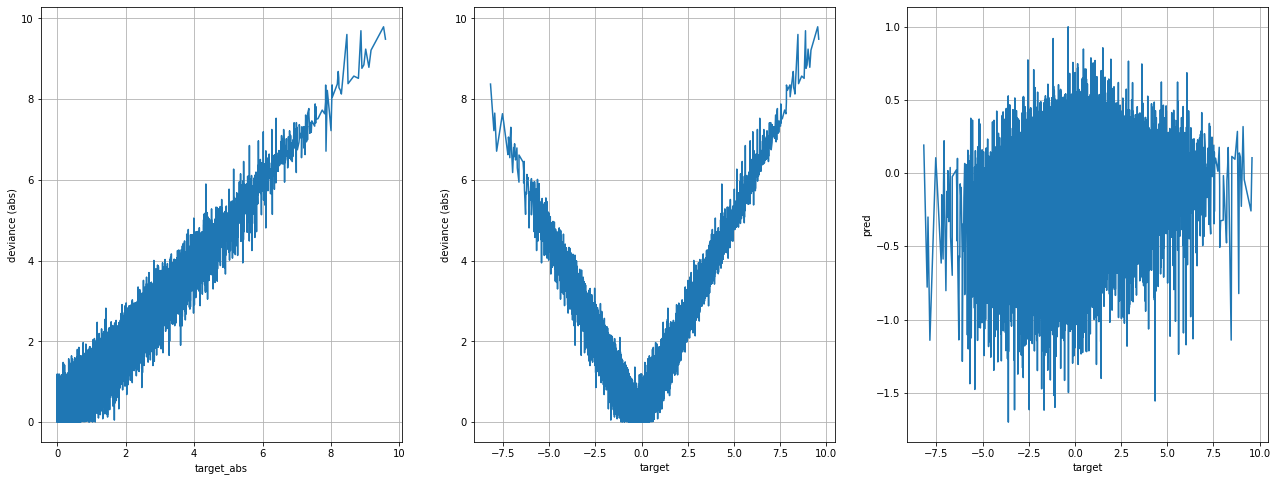

n_iterations: 361


In [10]:
pretrain = True
metrics = {"corr_mean":list(), "corr_std":list(), "error_mean":list(), "error_std":list(),}

if pretrain:
    
    models = list()

    for train_idx,valid_idx in splits:

        train_dset = lgb.Dataset(
            data=features.loc[train_idx,:],
            label=target.loc[train_idx,"target"].values,
            free_raw_data=True
        )
        valid_dset = lgb.Dataset(
            data=features.loc[valid_idx,:],
            label=target.loc[valid_idx,"target"].values,
            free_raw_data=True
        )
        
        es_callback = lgb.early_stopping(stopping_rounds=50, first_metric_only=False, verbose=False)
        log_callback = lgb.log_evaluation(period=20,)
        
        model = lgb.train(
            params=model_params,
            train_set=train_dset,
            num_boost_round=3000,
            valid_sets=[valid_dset,],
            feval=pearsonr,
            callbacks=[es_callback,log_callback],
        )
        models.append(model)

        lgb.plot_importance(model, figsize=(8,15), importance_type="split", max_num_features=30)
        lgb.plot_importance(model, figsize=(8,15), importance_type="gain", max_num_features=30)
        plt.show()
        
        # residual analysis on oof predictions
        oof = target.loc[valid_idx,:].copy()
        oof["time_id"] = time.loc[valid_idx,"time_id"]
        oof["pred"] = model.predict(features.loc[valid_idx,:])
        oof["target_abs"] = oof.eval("abs(target)")
        oof["dev"] = oof.eval("abs(target-pred)")

        corrs = oof.groupby("time_id").apply(lambda x: stats.pearsonr(x.target, x.pred)[0])
        corr_mean = corrs.mean()
        corr_std = corrs.std()
        error = oof.groupby("time_id").apply(lambda x: np.sqrt(np.mean((x.target-x.pred)**2)))
        error_mean = error.mean()
        error_std = error.std()
        
        metrics["corr_mean"].append(corr_mean)
        metrics["corr_std"].append(corr_std)
        metrics["error_mean"].append(error_mean)
        metrics["error_std"].append(error_std)

        plt.figure(figsize=(18,8))
        plt.subplot(1,2,1)
        corrs.plot()
        plt.axhline(
            y=corr_mean, 
            color='r', 
            linestyle='-', 
            label=f"corr_mean={corr_mean:.5f} & corr_std={corr_std:.5f}"
        )
        plt.grid()
        plt.ylabel("corr")
        plt.legend(loc="best")
        ##
        plt.subplot(1,2,2)
        error.plot()
        plt.axhline(
            y=error_mean, 
            color='r', 
            linestyle='-', 
            label=f"rmse_mean={error_mean:.5f} & error_std={error_std:.5f}"
        )
        plt.grid()
        plt.ylabel("rmse")
        plt.legend(loc="best")
        plt.show()

        plt.figure(figsize=(22,8))
        ##
        plt.subplot(1,3,1)
        plt.plot(oof.sort_values("target_abs").target_abs.values, oof.sort_values("target_abs").dev.values)
        plt.xlabel("target_abs")
        plt.ylabel("deviance (abs)")
        plt.grid()
        ##
        plt.subplot(1,3,2)
        plt.plot(oof.sort_values("target").target.values, oof.sort_values("target").dev.values)
        plt.xlabel("target")
        plt.ylabel("deviance (abs)")
        plt.grid()
        ##
        plt.subplot(1,3,3)
        plt.plot(oof.sort_values("target").target.values, oof.sort_values("target").pred.values)
        plt.xlabel("target")
        plt.ylabel("pred")
        plt.grid()
        plt.show()
           
    n_iterations = int(np.mean([m.best_iteration for m in models]))
    
else:
    # best value previously found
    n_iterations = 550
    

print("n_iterations:", n_iterations)

In [11]:
metrics

{'corr_mean': [0.14319948739133068, 0.1392279137990416, 0.14090960410798314],
 'corr_std': [0.08235956123617501, 0.07796887350804732, 0.09026317545097978],
 'error_mean': [0.8932647490068915, 0.9005626560503015, 0.9339654955038307],
 'error_std': [0.036277243847294964,
  0.032664109767886945,
  0.02451770565887605]}

In [12]:
# mean corr on validation
np.mean(metrics["corr_mean"])

0.14111233509945179

In [13]:
# mean rmse on validation
np.mean(metrics["error_mean"])

0.9092643001870079

***
## model training

[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 3141410, number of used features: 300
[LightGBM] [Info] Start training from score -0.021092
[20]	training's rmse: 0.913433	training's pearsonr: 0.146274
[40]	training's rmse: 0.910271	training's pearsonr: 0.162295
[60]	training's rmse: 0.908126	training's pearsonr: 0.175128
[80]	training's rmse: 0.906269	training's pearsonr: 0.187193
[100]	training's rmse: 0.904579	training's pearsonr: 0.198255
[120]	training's rmse: 0.902964	training's pearsonr: 0.208463
[140]	training's rmse: 0.901436	training's pearsonr: 0.217933
[160]	training's rmse: 0.899981	training's pearsonr: 0.226405
[180]	training's rmse: 0.898617	training's pearsonr: 0.23453
[200]	training's rmse: 0.897337	training's pearsonr: 0.241615
[220]	training's rmse: 0.895995	training's pearsonr: 0.249044
[240]	training's rmse: 0.894694	training's pearsonr: 0.25609
[260]	training's rmse: 0.893505	training's pearsonr: 0.262264
[280]	training'

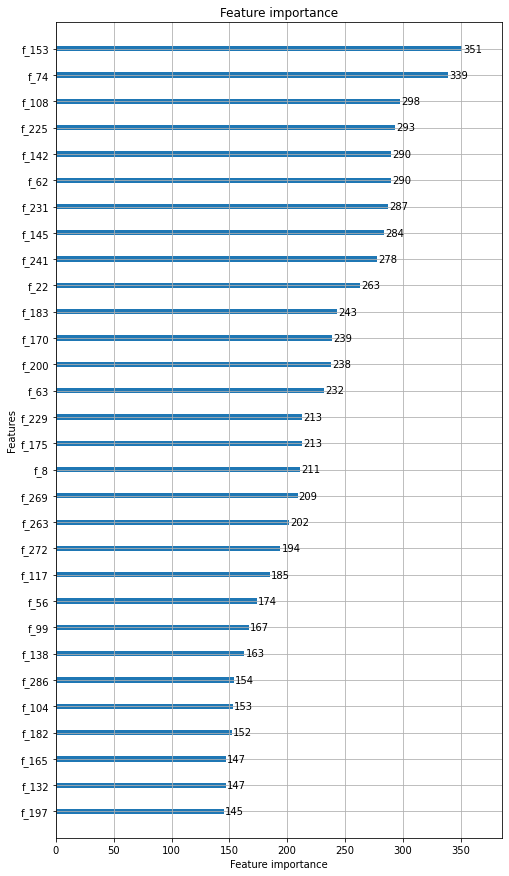

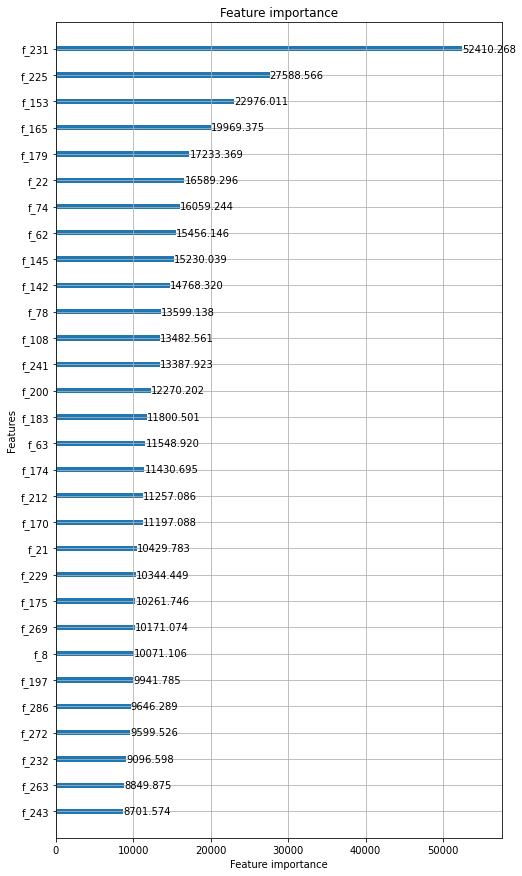

[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 3141410, number of used features: 300
[LightGBM] [Info] Start training from score -0.021092
[20]	training's rmse: 0.913469	training's pearsonr: 0.145671
[40]	training's rmse: 0.910326	training's pearsonr: 0.162286
[60]	training's rmse: 0.908098	training's pearsonr: 0.175604
[80]	training's rmse: 0.906207	training's pearsonr: 0.187672
[100]	training's rmse: 0.904557	training's pearsonr: 0.198339
[120]	training's rmse: 0.902889	training's pearsonr: 0.209022
[140]	training's rmse: 0.901437	training's pearsonr: 0.217927
[160]	training's rmse: 0.900036	training's pearsonr: 0.226184
[180]	training's rmse: 0.898703	training's pearsonr: 0.233864
[200]	training's rmse: 0.897291	training's pearsonr: 0.241962
[220]	training's rmse: 0.896021	training's pearsonr: 0.248906
[240]	training's rmse: 0.894824	training's pearsonr: 0.255337
[260]	training's rmse: 0.893582	training's pearsonr: 0.261928
[280]	trainin

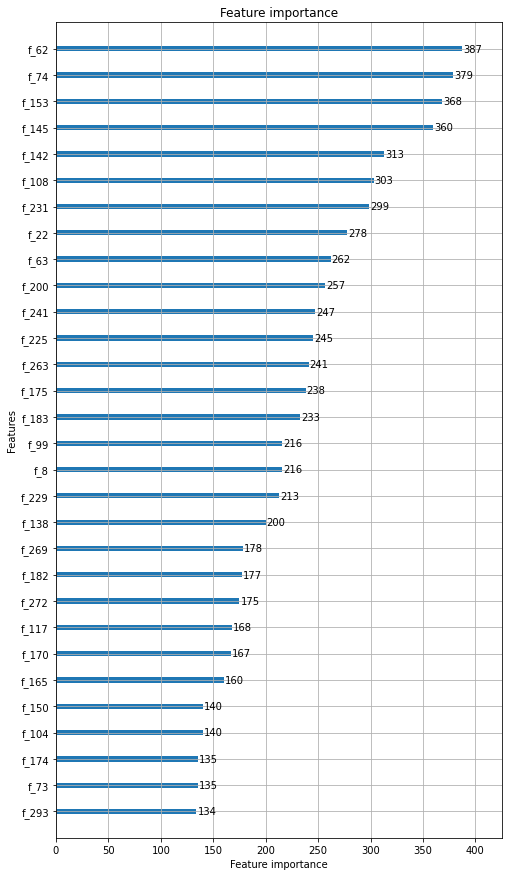

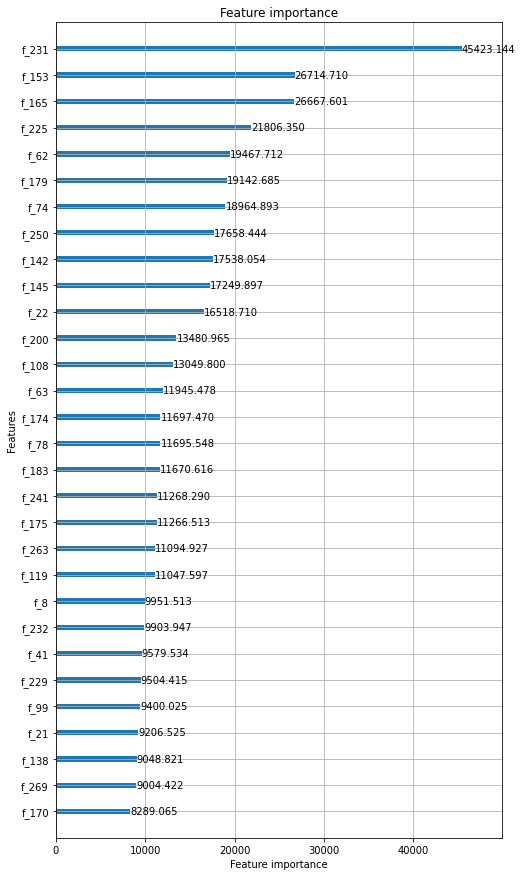

[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 3141410, number of used features: 300
[LightGBM] [Info] Start training from score -0.021092
[20]	training's rmse: 0.913546	training's pearsonr: 0.146385
[40]	training's rmse: 0.910402	training's pearsonr: 0.161822
[60]	training's rmse: 0.908178	training's pearsonr: 0.17535
[80]	training's rmse: 0.906299	training's pearsonr: 0.186942
[100]	training's rmse: 0.904634	training's pearsonr: 0.197633
[120]	training's rmse: 0.903025	training's pearsonr: 0.208004
[140]	training's rmse: 0.901384	training's pearsonr: 0.218487
[160]	training's rmse: 0.899924	training's pearsonr: 0.227074
[180]	training's rmse: 0.898548	training's pearsonr: 0.235241
[200]	training's rmse: 0.897077	training's pearsonr: 0.243396
[220]	training's rmse: 0.895773	training's pearsonr: 0.250459
[240]	training's rmse: 0.894554	training's pearsonr: 0.25683
[260]	training's rmse: 0.893342	training's pearsonr: 0.263254
[280]	training'

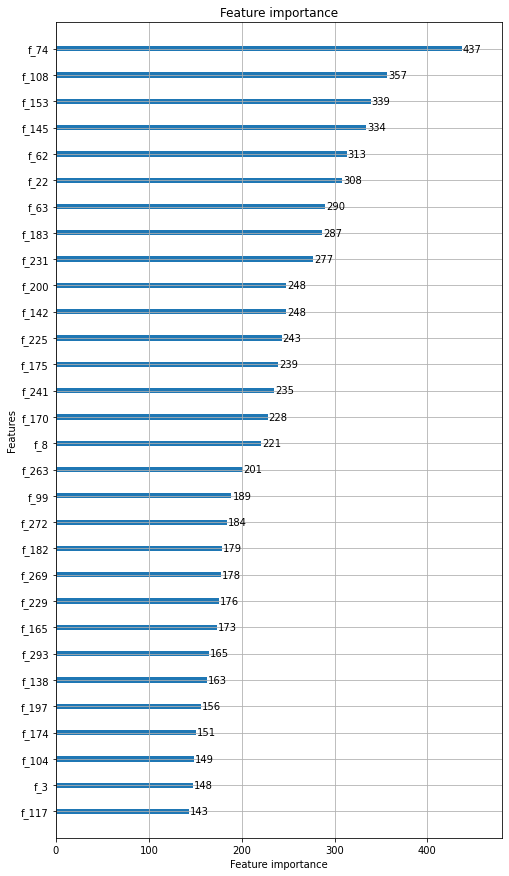

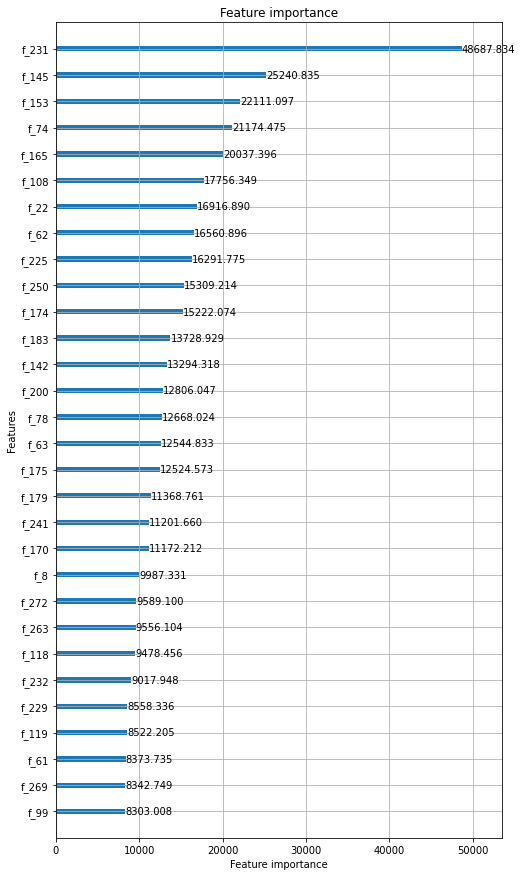

[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 3141410, number of used features: 300
[LightGBM] [Info] Start training from score -0.021092
[20]	training's rmse: 0.913444	training's pearsonr: 0.145717
[40]	training's rmse: 0.910338	training's pearsonr: 0.161742
[60]	training's rmse: 0.908032	training's pearsonr: 0.176744
[80]	training's rmse: 0.906215	training's pearsonr: 0.188022
[100]	training's rmse: 0.90453	training's pearsonr: 0.198641
[120]	training's rmse: 0.903031	training's pearsonr: 0.207975
[140]	training's rmse: 0.901594	training's pearsonr: 0.216757
[160]	training's rmse: 0.900076	training's pearsonr: 0.225896
[180]	training's rmse: 0.898715	training's pearsonr: 0.233899
[200]	training's rmse: 0.897359	training's pearsonr: 0.241661
[220]	training's rmse: 0.896085	training's pearsonr: 0.248642
[240]	training's rmse: 0.894823	training's pearsonr: 0.255293
[260]	training's rmse: 0.893623	training's pearsonr: 0.261532
[280]	training

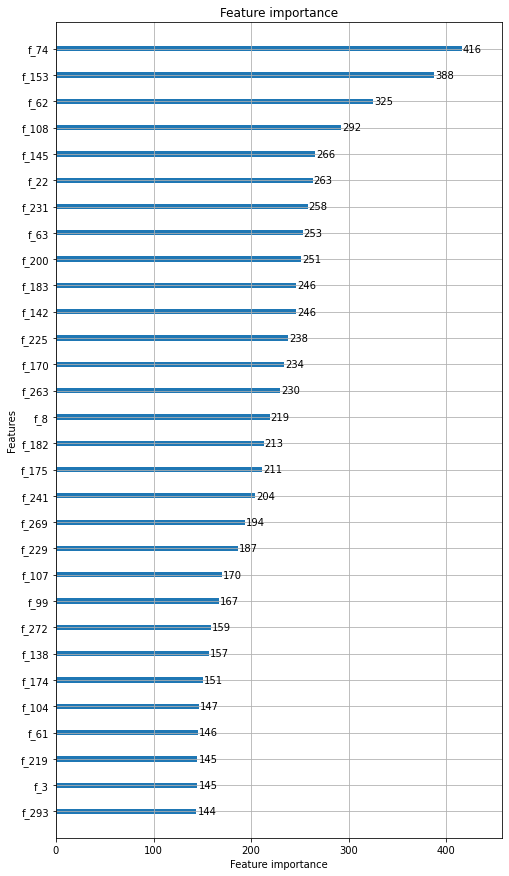

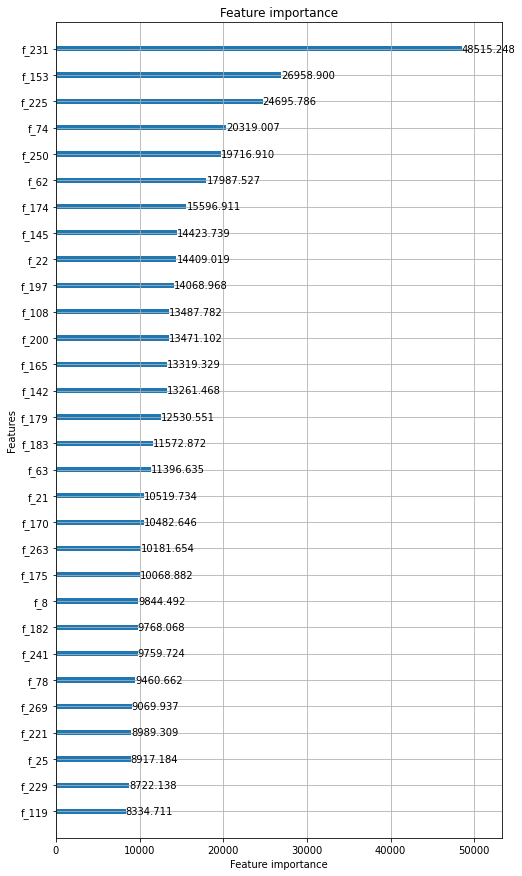

[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 3141410, number of used features: 300
[LightGBM] [Info] Start training from score -0.021092
[20]	training's rmse: 0.91346	training's pearsonr: 0.14646
[40]	training's rmse: 0.910423	training's pearsonr: 0.16189
[60]	training's rmse: 0.90811	training's pearsonr: 0.1761
[80]	training's rmse: 0.906248	training's pearsonr: 0.187747
[100]	training's rmse: 0.904563	training's pearsonr: 0.198524
[120]	training's rmse: 0.902953	training's pearsonr: 0.208912
[140]	training's rmse: 0.901392	training's pearsonr: 0.218576
[160]	training's rmse: 0.900002	training's pearsonr: 0.226681
[180]	training's rmse: 0.898676	training's pearsonr: 0.234255
[200]	training's rmse: 0.897339	training's pearsonr: 0.242064
[220]	training's rmse: 0.896014	training's pearsonr: 0.249174
[240]	training's rmse: 0.894755	training's pearsonr: 0.255979
[260]	training's rmse: 0.89359	training's pearsonr: 0.262022
[280]	training's rms

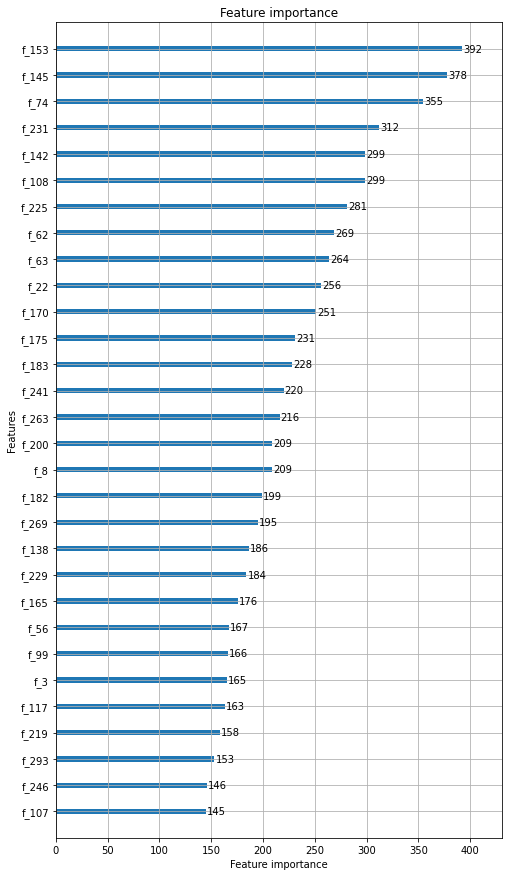

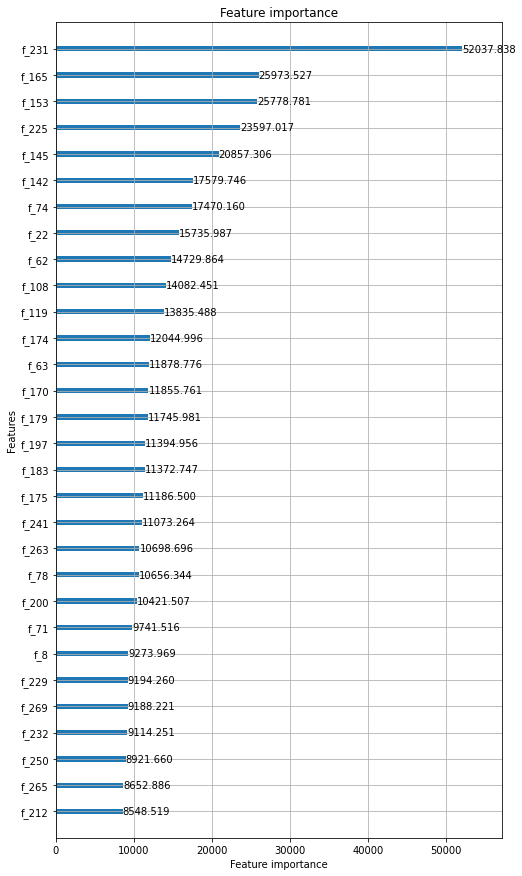

In [14]:
seeds = [2,7,11,19,23]
models = list()

train_dset = lgb.Dataset(
    data=features,
    label=target.target.values,
    free_raw_data=True
)

for seed in seeds:
    _model_params = dict(model_params)
    _model_params["seed"] = seed
    
    log_callback = lgb.log_evaluation(period=20)
    
    model = lgb.train(
        params=_model_params,
        train_set=train_dset,
        num_boost_round=n_iterations,
        valid_sets=[train_dset,],
        feval=pearsonr,
        callbacks=[log_callback,]
    )
    models.append(model)

    lgb.plot_importance(model, figsize=(8,15), importance_type="split", max_num_features=30)
    lgb.plot_importance(model, figsize=(8,15), importance_type="gain", max_num_features=30)
    plt.show()

In [15]:
for seed,model in zip(seeds,models): 
    model.save_model(f"../ump-artifacts/lgbm-linear/lgbm-seed{seed}.txt")

***
## inference

In [16]:
if current_env == "kaggle":

    import ubiquant
    env = ubiquant.make_env()  
    iter_test = env.iter_test()
    
    features = [f"f_{i}" for i in range(300)]
    for (test_df, sample_prediction_df) in iter_test:  
        preds = [model.predict(test_df[features]) for model in models]
        sample_prediction_df['target'] = np.mean(preds, axis=0)
        env.predict(sample_prediction_df) 
        display(sample_prediction_df)

***